In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler

2024-08-24 12:13:47.154076: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-24 12:13:47.154220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-24 12:13:47.307648: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_url="https://raw.githubusercontent.com/sap03rocks/mimic_lstm/main/noise_ppg%20_LSTM.csv"
test_url="https://raw.githubusercontent.com/sap03rocks/mimic_lstm/main/noise_ppg_only%20noisy%20data(5001-10000).csv"

# Read the data into a DataFrame
train_data = pd.read_csv(train_url, header=None)

train_data = train_data.drop(columns=[0,1,2,3])

# Read the data into a DataFrame
test_data = pd.read_csv(test_url, header=None)

print(train_data)
print(test_data)

                    4
0     noise_ppg(0.07)
1        -0.182085644
2          -0.2174345
3        -0.221738899
4        -0.221972954
...               ...
4997     -0.283802754
4998     -0.326083809
4999     -0.330652051
5000     -0.351254705
5001      -0.35279594

[5002 rows x 1 columns]
                0
0       noise_ppg
1     0.350581662
2     0.261023187
3     0.285805288
4     0.278772018
...           ...
4996  0.108147456
4997  0.101505445
4998  0.049388133
4999  0.060519955
5000  0.025183537

[5001 rows x 1 columns]


In [4]:
if isinstance(train_data, pd.DataFrame):
    train_data = train_data.iloc[:, 0]  # Select the first column or the relevant column
if isinstance(test_data, pd.DataFrame):
    test_data = test_data.iloc[:, 0]  # Select the first column or the relevant column

# Handle non-numeric values
train_data = pd.to_numeric(train_data, errors='coerce')
train_data = train_data.dropna()
test_data = pd.to_numeric(test_data, errors='coerce')
test_data = test_data.dropna()

# Reshape and scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data.values.reshape(-1, 1))
scaled_test_data = scaler.transform(test_data.values.reshape(-1, 1))

# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 8
X_train, y_train = create_sequences(scaled_train_data, seq_length)
X_test, y_test = create_sequences(scaled_test_data, seq_length)

# Reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

# Define model
model = Sequential()
model.add(Input(shape=(seq_length, n_features)))
model.add(Bidirectional(LSTM(500, return_sequences=True, activation='relu')))
model.add(Bidirectional(LSTM(300, return_sequences=True, activation='relu')))
model.add(Bidirectional(LSTM(200, return_sequences=True, activation='relu')))
model.add(Bidirectional(LSTM(50, return_sequences=True, activation='relu')))
model.add(Bidirectional(LSTM(10, return_sequences=False, activation='relu')))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Summarize model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 8, 1000)        │     2,008,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 8, 600)         │     3,122,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 8, 400)         │     1,281,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 8, 100)         │       180,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 20)             │         8,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,601,301 (25.18 MB)

 Trainable params: 6,601,301 (25.18 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Fit the model
history = model.fit(X_train, y_train, epochs=80, batch_size=20, validation_data=(X_test, y_test), verbose=1)


Epoch 1/80
  4/250 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.2355    

I0000 00:00:1724501662.181511      67 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - loss: 0.0326 - val_loss: 0.0015
Epoch 2/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 3/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 4/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 5/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 6/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 7/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0011 - val_loss: 9.6467e-04
Epoch 8/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 9.8924e-04 - val_loss: 9.1234e-04
Epoch 9/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 7.4562e-04 - val_loss: 9.2912e-04
Epoch 10/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 8.4249e-04 - val_loss: 0.0010
Epoch 11/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 9.2619e-04 - val_loss: 8.1047e-04
Epoch 12/80
250/250

In [6]:
# Assuming you have already trained your LSTM model
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
loss = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {loss}')
print("Test loss, test accuracy:", loss)

# Generate predictions (probabilities) on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(X_test[:3])
print("Predictions shape:", predictions.shape)

Evaluate on test data
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 8.5194e-04
Test Loss: 0.0008469459135085344
Test loss, test accuracy: 0.0008469459135085344
Generate predictions for 3 samples
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predictions shape: (3, 1)


In [7]:


# Assuming you have already trained your LSTM model
# Generate predictions for the entire dataset
predictions = model.predict(X_test)
print(predictions)

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['Prediction'])

# Save the DataFrame to a CSV file
predictions_df.to_csv('predictions.csv', index=False)

print("Predictions saved to predictions.csv")


156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
[[0.7029786 ]
 [0.690204  ]
 [0.68968105]
 ...
 [0.6088544 ]
 [0.59488153]
 [0.5825231 ]]
Predictions saved to predictions.csv


In [8]:
# Predict on the training data
train_predict = model.predict(X_train)

# Predict on the testing data
test_predict = model.predict(X_test)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


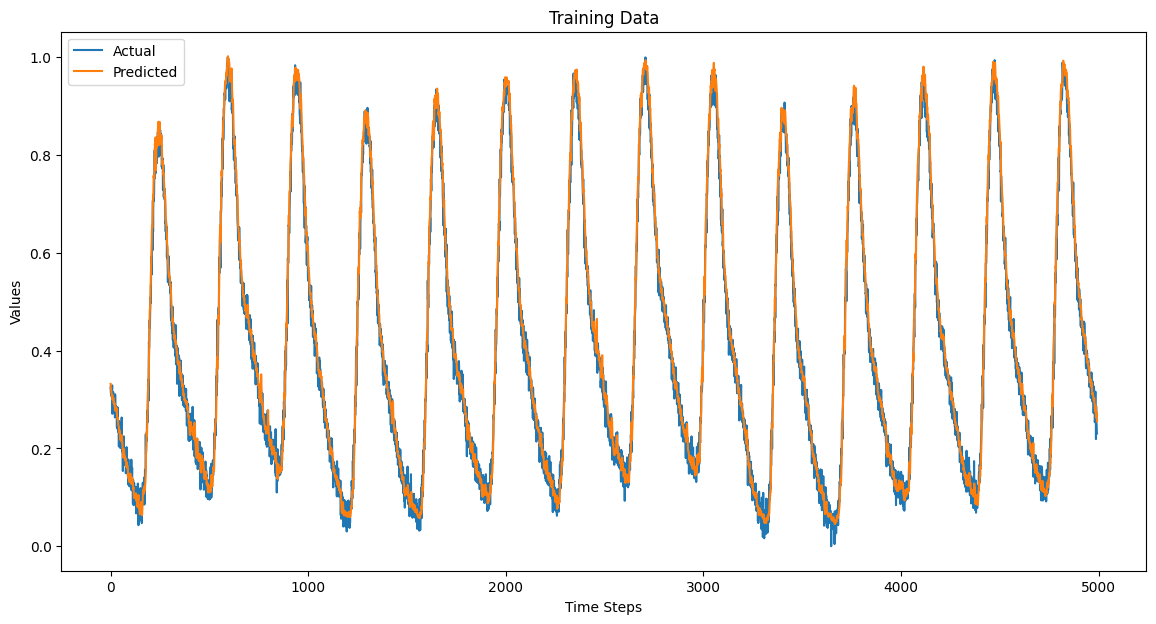

In [9]:
import matplotlib.pyplot as plt

# Predict on the training data
train_predict = model.predict(X_train)

# Predict on the testing data
test_predict = model.predict(X_test)

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot training data

plt.plot(y_train, label='Actual')
plt.plot(train_predict, label='Predicted')
plt.title('Training Data')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()


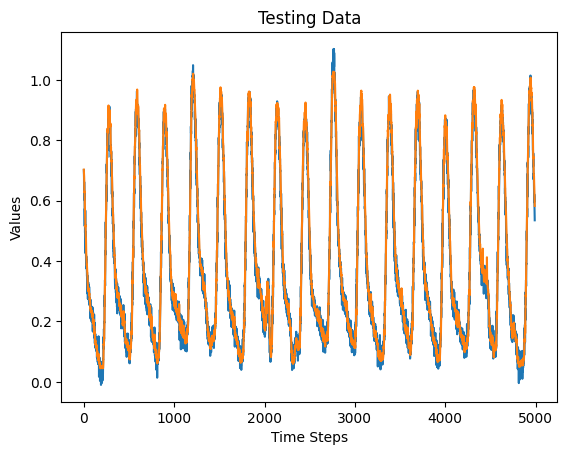

In [10]:
plt.plot(y_test, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.title('Testing Data')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.show()

In [11]:
# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Actual': y_test.flatten(),  # Flatten in case y_test is not 1D
    'Predicted': test_predict.flatten()  # Flatten in case test_predict is not 1D
})

# Save the DataFrame to a CSV file
results_df.to_csv('test_vs_actual.csv', index=True)

print("Test vs Actual results saved to test_vs_actual.csv")


Test vs Actual results saved to test_vs_actual.csv


156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MSE: 0.0013039900309241854
MAE: 0.028475824301150914
R^2: 0.988426049120176


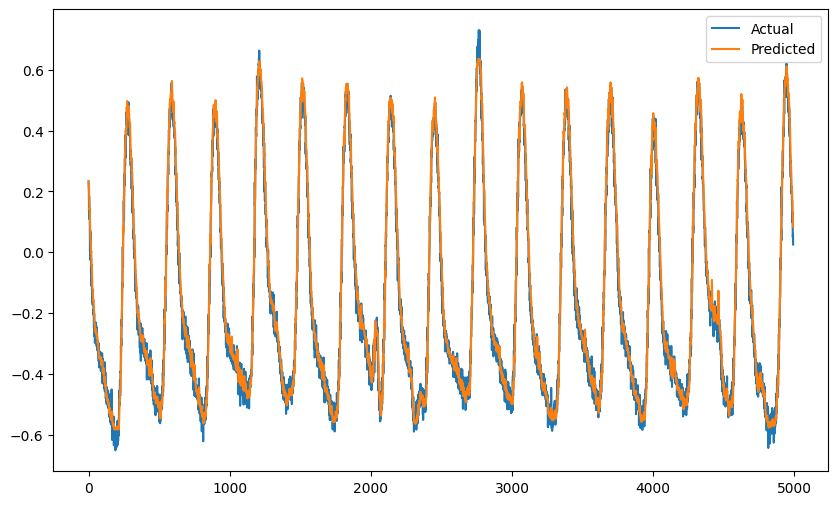

<Figure size 640x480 with 0 Axes>

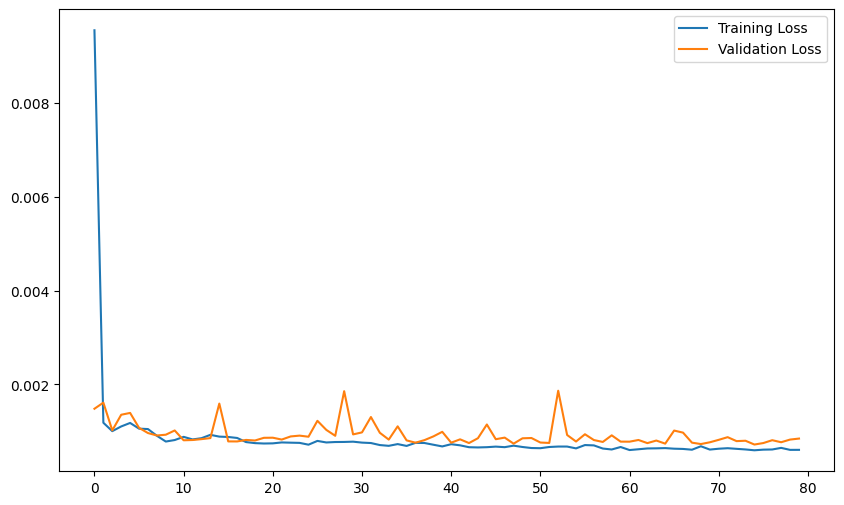

<Figure size 640x480 with 0 Axes>

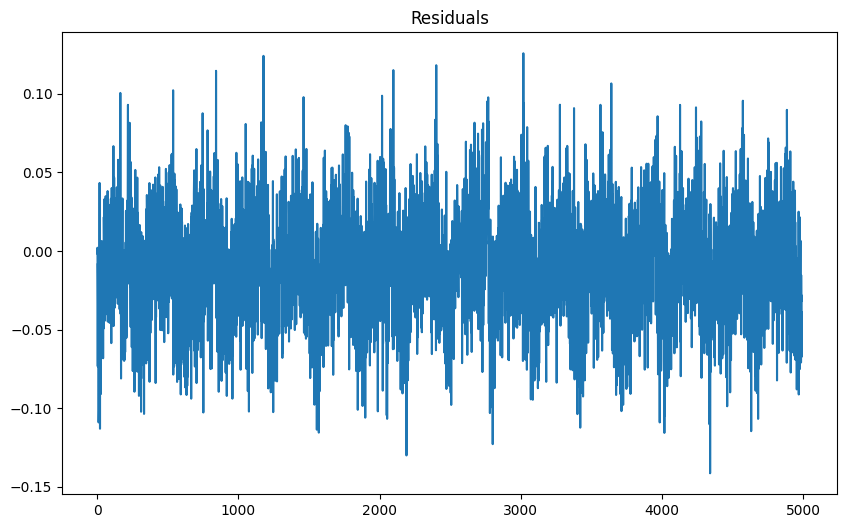

<Figure size 640x480 with 0 Axes>

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# make predictions
y_pred = model.predict(X_test)

# inverse transform predictions
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')

# plot predictions vs. actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.legend()
plt.show()
plt.savefig('predictions_vs_actual.png')

# plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
plt.savefig('training_validation.png')
# plot residuals
residuals = y_test_inv - y_pred_inv
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()
plt.savefig('residual.png')
